# Adding inhibition to stable networks to find maximum ratio of spike pulse propagation speeds
Here, we add inhibition, modeled as global Poisson input to the chain, to stable networks identified in D2a and D2b.

## Hyperparams

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=2e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, E_A=-0.1, T_E=.002, T_I=.002, T_A=0.01,

    # NTWK ARCHITECTURE
    N_L=60,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    N_P_I = 200, # num nrns in inhibitory pool
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_I=0.1e-3,
    W_A=0, # adaptation weight for all neurons
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

def set_dynamic_vars(m):
    m.N_E = m.N_L * m.N_L_E
    m.N_N = m.N_E + m.N_P_I

set_dynamic_vars(M)

## SMLN
S = Generic(RNG_SEED=0, DT=.0005)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


# Redefine functions for simulating a single set of parameters
Specific comments on this code to be found in notebook D1

### Redefine helper functions from D2a and D2b

In [2]:
def spk_tms_for_link(spks_t, spks_c, idx, n_l_e):
    link_start_idx = idx * n_l_e
    window = (spks_c >= link_start_idx) & (spks_c < (link_start_idx + n_l_e))
    return spks_t[window]

def tms_for_link(spks_t, spks_c, n_l, n_l_e):
    return [spk_tms_for_link(spks_t, spks_c, i, n_l_e) for i in range(n_l)]

### Helper functions for defining connectivity

In [432]:
# see D1 for specific comments on these functions

## E-E weights
def make_w_r_e(m, w_e_i_r, w_e_e_r, w_e_e_f, percent_cnxn_e_e, percent_cnxn_e_i):
    w_r_e = np.zeros([m.N_N]*2)

    w_r_e_e = w_e_e_f * np.kron(np.eye(m.N_L, k=-1), np.ones([m.N_L_E]*2))  # btwn links
    for i in range(m.N_L):
        w_r_e_e[(i * m.N_L_E):((i+1) * m.N_L_E), (i * m.N_L_E):((i+1) * m.N_L_E)] = \
            w_e_e_r * sprs_mat_with_rand_percent_cnxns((m.N_L_E, m.N_L_E), percent_cnxn_e_e)

    w_r_e[:m.N_E, :m.N_E] = w_r_e_e
    w_r_e[m.N_E:, :m.N_E] = w_e_i_r * sprs_mat_with_rand_percent_cnxns((m.N_E, m.N_P_I), percent_cnxn_e_i)
    
    return w_r_e

def make_w_r_i(m, w_i_e_r):
    w_r_i = np.zeros((m.N_N, m.N_N))
    w_r_i[:m.N_E, m.N_E:] = w_i_e_r * np.ones([m.N_E, m.N_P_I])
    return w_r_i

def make_w_u_i(m, w_uv):
    w_u_i = np.zeros([m.N_N, m.N_N + m.N_L_E])
    w_u_i[:(-m.N_P_I), m.N_L_E:(-m.N_P_I)] = w_uv * np.eye(m.N_E)
    return w_u_i

### Define function for simulating a single set of parameters with zero inhibition and 800 Hz inhibition

In [442]:
def run_test(m_t, w_e_i_r, w_i_e_r, w_e_e_r, w_e_e_f, w_uv, percent_cnxn_e_e, percent_cnxn_e_i,
             show_connectivity=False, repeats=1):

    ## input weights
    w_u = {
        # localized inputs to trigger activation from start of chain
        'E': np.block([
            [ 0.01 * np.eye(m_t.N_L_E), np.zeros([m_t.N_L_E, m_t.N_N]) ],
            [ np.zeros([m_t.N_N - m_t.N_L_E, m_t.N_N + m_t.N_L_E]) ],
        ]),

        # global inhibitory inputs across chain
        'I': make_w_u_i(m_t, w_uv)
    }

    # inputs
    t = np.arange(0, S.T, S.DT)
    t_u = [.01, .013]
    t_mask = (t_u[0] <= t) & (t < t_u[1])
    
    all_rsps = []
    FQ_SPK_U_I = [0, 800]
    
#     spks_u_per_fq = []
#     for i_fq, fq in enumerate(FQ_SPK_U_I):
#         spks_u_per_fq.append(spks_u_base.copy())
#         spks_u_per_fq[i_fq][:, m_t.N_L_E:(m_t.N_E + m_t.N_L_E)] = np.random.poisson(fq * S.DT * w_uv, (len(t), m_t.N_E))
    
    for rp_idx in range(repeats):

        # make ntwk
        L_MAX_V = 10  # max num links to plot voltage for

        rsps_for_trial = []
        
        w_r = {
            'E': make_w_r_e(m_t, w_e_i_r, w_e_e_r, w_e_e_f, percent_cnxn_e_e, percent_cnxn_e_i),
            'I': make_w_r_i(m_t, w_i_e_r),
            'A': m_t.W_A * np.eye(m_t.N_N),
        }
        
        if show_connectivity and rp_idx == 0:
            fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)
            axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
            axs[0].set_title('W_R[E]\n')
            axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
            axs[1].set_title('W_R[I]\n')

            axs[2].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
            axs[2].set_title('W_U[E]\n')
            axs[3].spy(w_u['I'], markersize=1)
            axs[3].set_title('W_U[I]\n')

            for ax in axs.flatten():
    #             ax.set_xlim(0, 200)
    #             ax.set_ylim(200, 0)
                set_font_size(ax, 14)
        
        ## external currents
        i_ext = m_t.SGM_N/S.DT * np.random.randn(len(t), m_t.N_N) + m_t.I_EXT_B
        
        ## inp spks
        spks_u_base = np.zeros((len(t), m_t.N_L_E + m_t.N_N), dtype=int)

        # trigger inputs
        tmp = cc([np.ones(m_t.N_L_E, int), np.zeros(m_t.N_L_E*(t_mask.sum()-1))])
        spks_u_base[t_mask, :m_t.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m_t.N_L_E)

        for fq_idx, fq_spk_u_i in enumerate(FQ_SPK_U_I):

            ntwk = LIFNtwkG(
                c_m=m_t.C_M_E,
                g_l=m_t.G_L_E,
                e_l=m_t.E_L_E,
                v_th=m_t.V_TH_E,
                v_r=m_t.E_L_E,
                t_r=m_t.T_R_E,
                e_s={'E': M.E_E, 'I': M.E_I, 'A': M.E_A},
                t_s={'E': M.T_E, 'I': M.T_E, 'A': M.T_A},
                w_r=w_r,
                w_u=w_u)

            clamp = Generic(
                v={0: np.repeat(m_t.E_L_E, m_t.N_N)}, spk={})
            
            spks_u = spks_u_base.copy()
            spks_u[:, m_t.N_L_E:-(m_t.N_P_I)] = np.random.poisson(fq_spk_u_i * S.DT, (len(t), m_t.N_E))

            # run smln
            rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

            rsps_for_trial.append({
                'spks_t': copy(rsp.spks_t),
                'spks_c': copy(rsp.spks_c),
                'spks_u': spks_u.nonzero(),
            })
        
        all_rsps.append(rsps_for_trial)
    
    return all_rsps

# Speed control via INH input

In [164]:
S.T = 0.3

m = copy(M)
m.N_L = 40

set_dynamic_vars(m)

In [186]:
# for 'n_trials' iterations, simulate a network with a given set of params and use 'w_uv' to modulate the level of inhibition
def test_reliability(m, params, w_uv, n_trials):
    results = run_test(m, 0, 0, params['weer'], params['weef'], w_uv, params['cxneep'], 1.,
             show_connectivity=False, repeats=n_trials)
    
    slp_ratios = []
    
    for res in results:
        slopes = []

        # compute slopes of each trial
        for frq_idx, frq_res in enumerate(res):
            tms_p_link = tms_for_link(frq_res['spks_t'], frq_res['spks_c'], m.N_L, m.N_L_E)
            mean_tms_p_link = np.array([np.mean(tms_for_link) for tms_for_link in tms_p_link])
            x = np.arange(m.N_L) + 1
            slp, icpt = stats.linregress(x, mean_tms_p_link)[:2]
            slopes.append(slp)
        
        # take the ratio of slopes with and without 800 Hz inhibition
        slp_ratios.append(slopes[1] / slopes[0])
    
    slp_ratios = np.array(slp_ratios)
    non_nan_slp_ratios = slp_ratios[~np.isnan(slp_ratios)] # drop undefined slope ratios
    mean = np.mean(non_nan_slp_ratios)
    std = np.std(non_nan_slp_ratios)
    success_rate = float(len(non_nan_slp_ratios)) / n_trials
    
    return np.array([mean, std, success_rate, w_uv]) # return stats on experiments including mean slope, std slope
    # trial success rate, and weight of external inhibition
    

In [190]:
# for a set of UVA weights (external inhibition weights), test the reliability of a network for a given number of trials
def gen_reliability_curve(m, params, uv_weights, n_trials_per_point=5):
    stats_per_w_uv = []
    for w_uv in uv_weights:
        stats_per_w_uv.append(test_reliability(m, params, w_uv, n_trials_per_point))
    all_stats = np.stack(stats_per_w_uv)
    return all_stats

Now, load stable weights from the prior notebooks:

In [196]:
df_for_cnxc = pickle.load(open(f'./data/exp_2020-07-03--10:38/stable_weights_per_6.p', 'rb'))
df_for_cnxc

,weer,weef,cxneep
5,0.000001,0.000023,0.6
7,0.000001,0.000026,0.6
19,0.000003,0.000023,0.6
21,0.000004,0.000023,0.6
22,0.000004,0.000023,0.6
...,...,...,...
166,0.000018,0.000013,0.6
171,0.000019,0.000010,0.6
179,0.000020,0.000010,0.6
187,0.000020,0.000010,0.6


Set up the hyperparams to allow simulation of networks with adapation present

In [427]:
m2 = copy(m)
m2.N_L = 80
m2.W_A = .05e-3
set_dynamic_vars(m2)
params_adaptation = [df_for_cnxc.iloc(0)[i] for i in range(0, 65, 5)]

In [197]:
stats_for_all_params = []

for idx in range(0, 65, 5): 
    stats_for_all_params.append(gen_reliability_curve(m2, df_for_cnxc.iloc(0)[idx], np.linspace(0.1e-4, 4e-4, 30)))

### Define additional helper functions to identify networks that reliably propagate spike pulses with inhibition present

In [433]:
# identify the maximum ratio of spike pulse propagation speeds that transmits spike pulses for 100% of trials
def find_max_modulation_with_no_failure(reliability_stats):
    no_failure_stats = reliability_stats[reliability_stats[:, 2] == 1.]
    if no_failure_stats.shape[0] is 0:
        return 0
    max_modulation = np.max(no_failure_stats[:, 0])
    return max_modulation

# identify maximum inhibition that can be applied and that permits transmition of spike pulses for 100% of trials
def find_max_inhibition_with_no_failure(reliability_stats):
    no_failure_stats = reliability_stats[reliability_stats[:, 2] == 1.]
    if no_failure_stats.shape[0] is 0:
        return 0
    max_inhibition = np.max(no_failure_stats[:, 3])
    return max_inhibition

def graph_reliability_curve(params, all_stats):
    gs = gridspec.GridSpec(2, 3)
    fig = plt.figure(figsize=(20, 10), tight_layout=True)
    axs = [fig.add_subplot(gs[:, 2]), fig.add_subplot(gs[0, :2]), fig.add_subplot(gs[1, :2])]
    
    colors = list(Color('blue').range_to(Color('green'), len(all_stats)))

    for idx, reliability_stats in enumerate(all_stats):
        axs[0].scatter(params[idx]['weer'], params[idx]['weef'], color=colors[idx].hex, s=40)
        axs[1].bar(idx + 0.5, find_max_modulation_with_no_failure(reliability_stats),  color=colors[idx].hex)
        axs[2].bar(idx + 0.5, find_max_inhibition_with_no_failure(reliability_stats),  color=colors[idx].hex)
        
    axs[0].set_xlabel('Exc -> Exc Recurrent Weight')
    axs[0].set_ylabel('Exc -> Exc Feed-Forward Weight')
    axs[0].set_xlim(0, 1.8e-5)
    axs[0].set_ylim(0, 2.5e-5)

    axs[1].set_ylabel('Ratio of Fastest Propagation Speed to Slowest\n at 0% Failure')
    axs[1].set_xticks([])
    axs[1].set_ylim(0, 3.5)
    
    axs[2].set_xticks([])
    axs[2].set_ylabel('Max Inh Weight with 0% Failure')
    for ax in axs:
        set_font_size(ax, 18)

# Results for networks with adapation

### Example simulation of network with 60% intralink connectivity and adaption weight = 0.05e-3

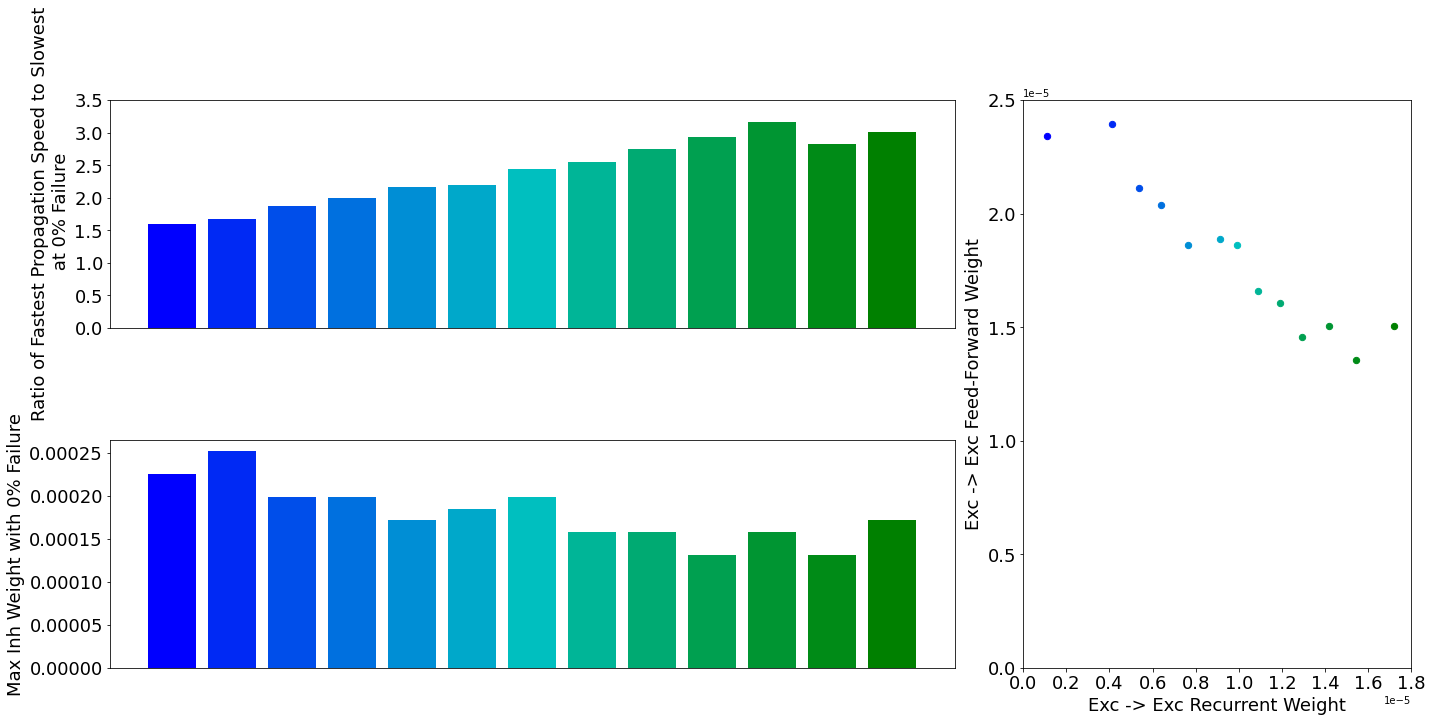

In [420]:
graph_reliability_curve(params_adaptation, stats_for_all_params)

Regime of strong feed-forward weights tolerates more inhibition than regime of large recurrent, small feed-forward, but not enough to produce speed propagation?

### Define a function for graphing spike pulse propagation at 0 and 800 Hz inhibition for a single inhibitory weight value

In [ ]:
def quick_plot(m, w_e_i_r, w_i_e_r, w_e_e_r, w_e_e_f, w_uva, percent_cnxn_e_e, percent_cnxn_e_i,
               overlay=False, repeats=1, show_connectivity=True, n_show_only=None):
    # w_e_i_r_range, w_i_e_r_range, w_e_e_r_range, w_e_e_f_range, uva_range
    all_rsps = run_test(m, w_e_i_r, w_i_e_r, w_e_e_r, w_e_e_f, w_uva, percent_cnxn_e_e, percent_cnxn_e_i,
                    show_connectivity=show_connectivity, repeats=repeats)
    
    inv_slope_rs = []
    
    for idx_r, rsps in enumerate(all_rsps):
        show_trial = (type(n_show_only) is int and idx_r < n_show_only)

        if overlay and show_trial:
            gs = gridspec.GridSpec(7, 1)
            fig = plt.figure(figsize=(10, 20), tight_layout=True)
            axs = [fig.add_subplot(gs[1:3]), fig.add_subplot(gs[3]), fig.add_subplot(gs[4:])]

        colors = ['red', 'blue', 'green']
        inv_slopes = []

        for frq_idx, frq_res in enumerate(rsps):
            tms_p_link = tms_for_link(frq_res['spks_t'], frq_res['spks_c'], m.N_L, m.N_L_E)
            mean_tms_p_link = np.array([np.mean(tms_for_link) for tms_for_link in tms_p_link])
            x = np.arange(m.N_L) + 1
            slp, icpt = stats.linregress(x, mean_tms_p_link)[:2]

            inv_slope = 1./slp
            inv_slopes.append(inv_slope)
            
            if show_trial:
                if not overlay:
                    gs = gridspec.GridSpec(7, 1)
                    fig = plt.figure(figsize=(10, 20), tight_layout=True)
                    axs = [fig.add_subplot(gs[1:3]), fig.add_subplot(gs[3]), fig.add_subplot(gs[4:])]

                raster = np.stack([frq_res['spks_t'], frq_res['spks_c']])
                inh_raster = raster[:, raster[1, :] >= m.N_E]
                exc_raster = raster[:, raster[1, :] < m.N_E]

                axs_1_color = 'red' if not overlay else colors[frq_idx]

                axs[1].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - m.N_E + frq_idx * m.N_P_I,
                               s=1, c=axs_1_color, zorder=0, alpha=.8)
                axs[1].set_ylabel('Inh Cell Index')
                axs[1].set_xlabel('Time (ms)')
                axs[1].set_ylim(-1, 3 * m.N_P_I)

                for i in range(2):
                    axs[i].set_xlim(0, S.T * 1000)

                axs[0].set_title(f'Inhibition: {int(frq_idx * 400)} Hz')
                axs[0].set_ylim(-1, m.N_E)
                axs[0].set_ylabel('Exc Cell Index')
                axs[0].set_xlabel('Time (ms)')
                axs[2].set_ylim(1100, 1200)
                axs[2].set_ylabel('Exc Cell Index')
                axs[2].set_xlabel('Time (ms)')

                for l_cntr in range(m.N_L):
                    link_window = (exc_raster[1, :] >= l_cntr * m.N_L_E) & (exc_raster[1, :] < ((l_cntr + 1) * m.N_L_E))
                    link_spks = exc_raster[:, link_window]
                    if overlay:
                        c = colors[frq_idx]
                    else:
                        c = 'black' if l_cntr % 2 == 0 else 'grey'
                    axs[0].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
                    axs[2].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
                    axs[0].plot(link_spks[0, :] * 1000, m.N_L_E * (link_spks[0, :] - icpt) * inv_slope, c='black')
        inv_slope_ratio = inv_slopes[0] / inv_slopes[-1]
        inv_slope_rs.append(inv_slope_ratio)
        if overlay and show_trial:
            axs[0].set_title(f'inv_slp: {inv_slope_ratio}')
    return np.array(inv_slope_rs)

### Example of a network with adapation that permits large modulation of spike pulse propagation speed
Run for N=100 trials

In [ ]:
np.random.seed(seed=0)
'''
    Parameters:
        0. Generic class with hyperparams
        1. excitatory -> inhibitory weight
        2. inhibitory -> excitatory weight
        3. excitatory -> excitatory recursive (within chainlink) weight
        4. excitatory -> excitatory feed-forward (chainlink -> chainlink) weight
        5. weight of external inhibition
        6. fraction of total nuerons in excitatory chainlink that a single excitatory cell receieves afferents from'
        7. fraction of total nuerons in entire chain that a single inhibitory cell receieves afferents from
'''
slopes = quick_plot(m2, 0, 0, 1.4e-5, 1.5e-5, 1e-4, .6, 1., overlay=True, repeats=100, n_show_only=3)
print('slope mean:', slopes.mean())
print('slope std:', slopes.std())

### Repackaging of some of the functionality above
I didn't re-run the above with this new function because it took a long time to run

In [244]:
def reliability_curve_for_params(m, params_path, uv_weights, n_trials_per_point=8, sample_every=5):
    df_for_params = pickle.load(open(params_path, 'rb'))
    print(len(df_for_params))
    stats_for_all_params = []
    for idx in range(0, len(df_for_params), sample_every):
        stats_for_all_params.append(gen_reliability_curve(m, df_for_params.iloc(0)[idx], uv_weights,
                                                          n_trials_per_point=n_trials_per_point))
    return stats_for_all_params

# Results for params without adapation

In [416]:
res = reliability_curve_for_params(m, './data/exp_2020-07-01--13:42/stable_weights_per_6.p', np.linspace(0.1e-4, 1.8e-4, 50),
                             n_trials_per_point=5, sample_every=1)

res_for_per_6 = res

42


### Results for 60% intralink connectivity (no adaptation)

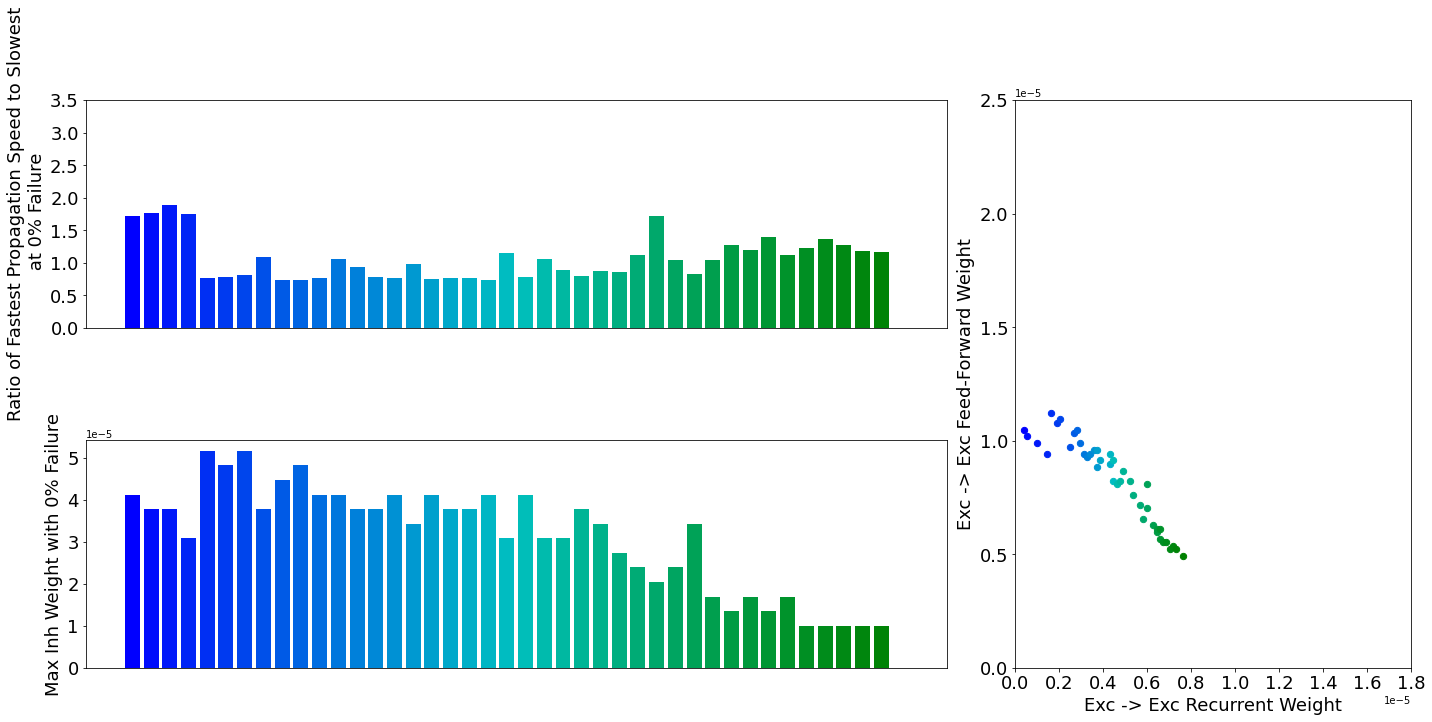

In [421]:
df_for_params = pickle.load(open('./data/exp_2020-07-01--13:42/stable_weights_per_6.p', 'rb'))
params_for_per_6 = [df_for_params.iloc(0)[idx] for idx in range(len(df_for_params))]
graph_reliability_curve(params_for_per_6, res_for_per_6)

### Example simulation of network without adaptation
The network has 60% intralink connectivity and is heavily feed-forward (blue points above). Run for N=100 trials.

slope mean: 1.823617632446246
slope std: 0.04420257312354092


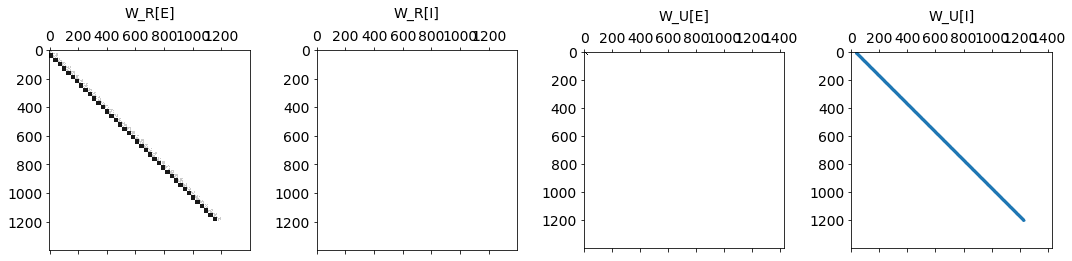

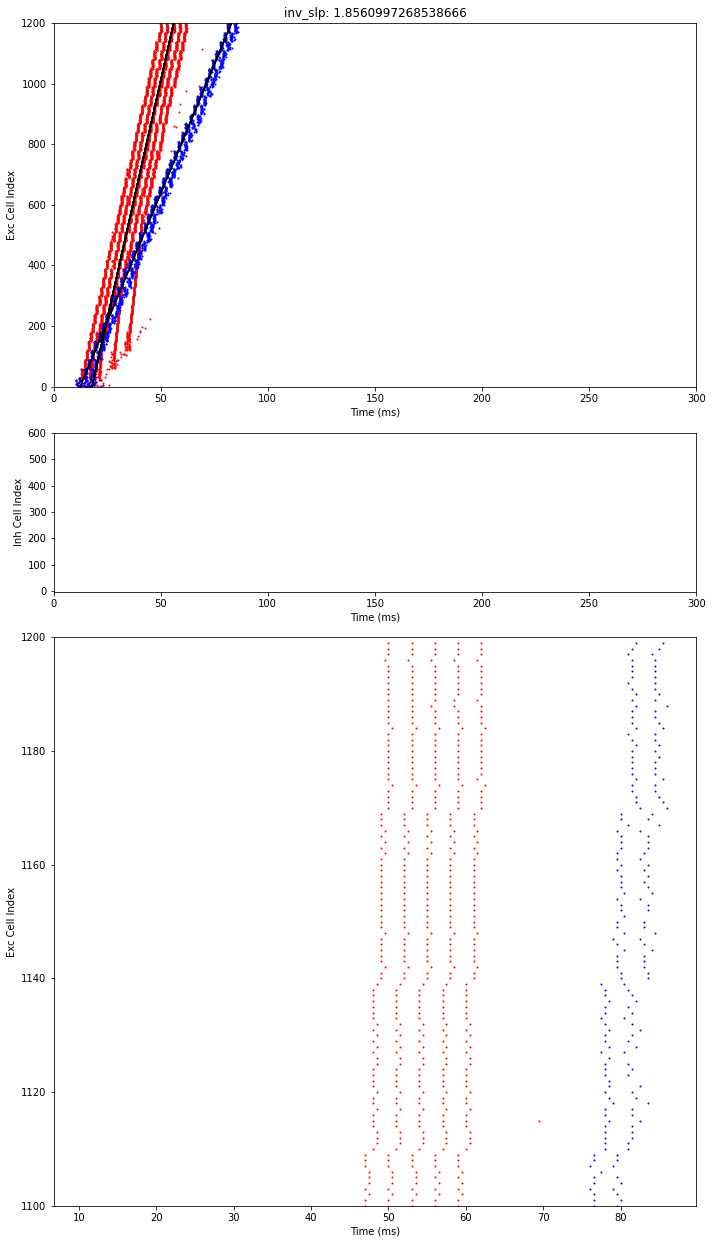

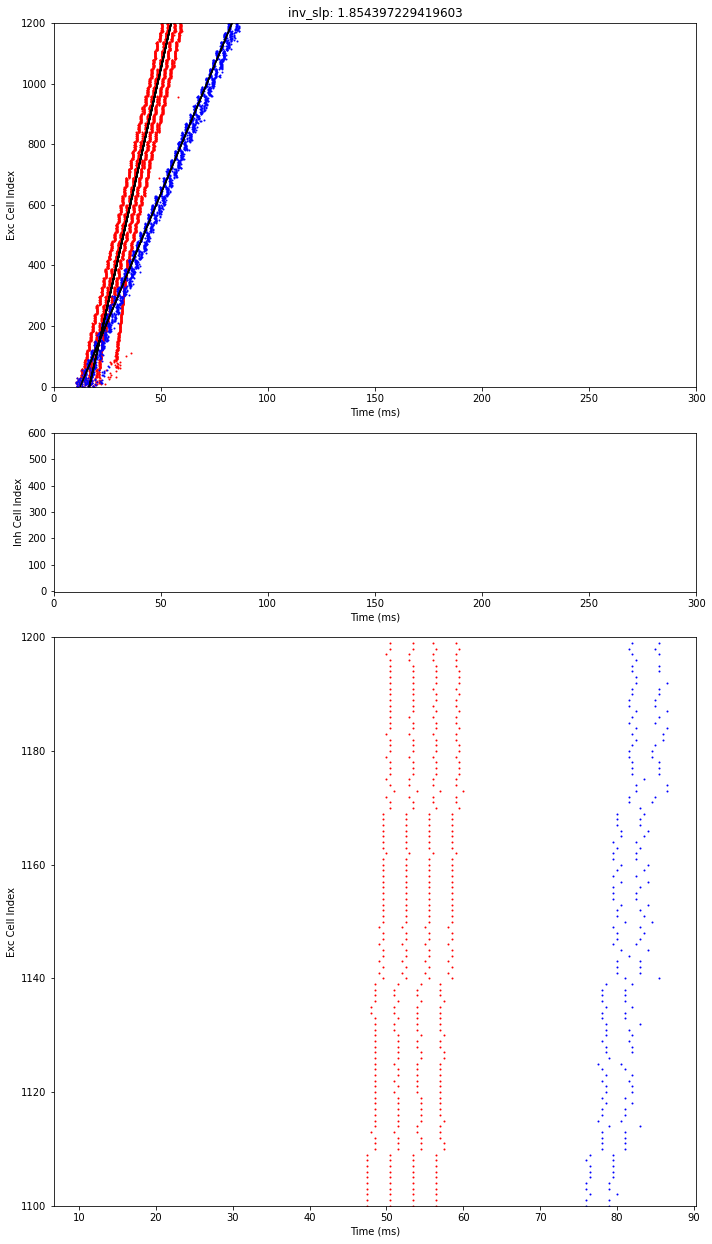

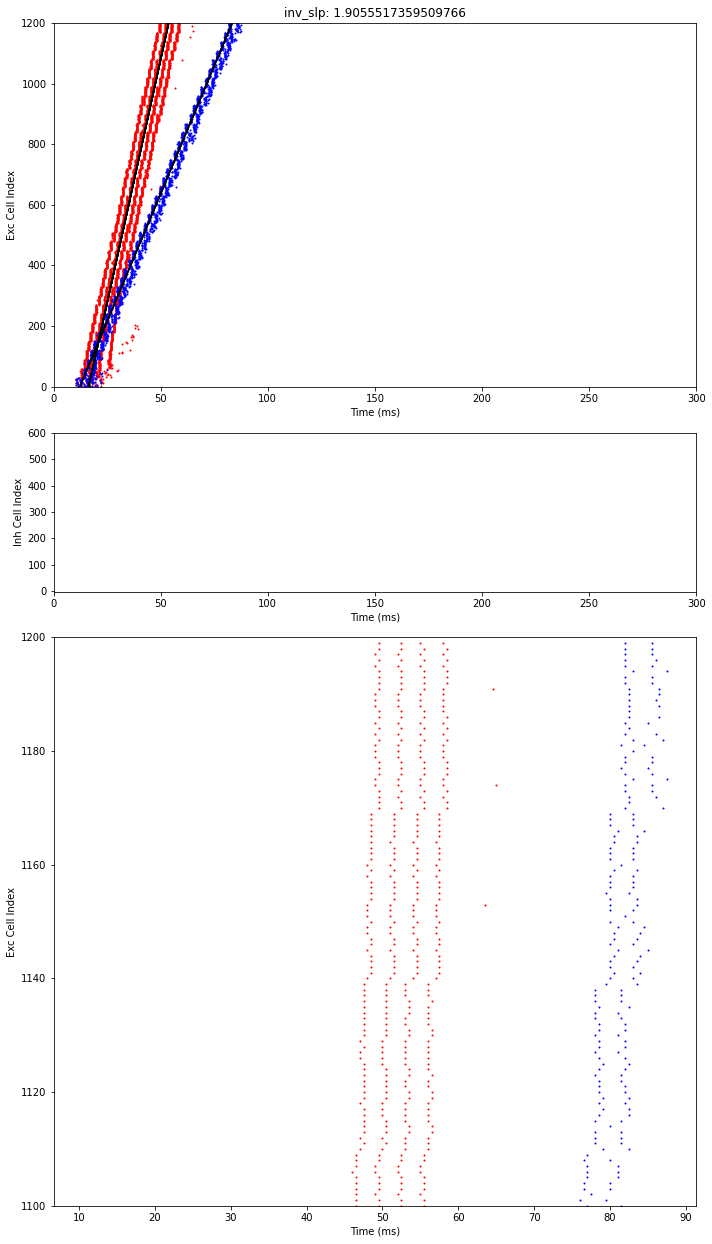

In [474]:
'''
    Parameters:
        0. Generic class with hyperparams
        1. excitatory -> inhibitory weight
        2. inhibitory -> excitatory weight
        3. excitatory -> excitatory recursive (within chainlink) weight
        4. excitatory -> excitatory feed-forward (chainlink -> chainlink) weight
        5. weight of external inhibition
        6. fraction of total nuerons in excitatory chainlink that a single excitatory cell receieves afferents from'
        7. fraction of total nuerons in entire chain that a single inhibitory cell receieves afferents from
'''
slopes = quick_plot(m, 0, 0, 2e-6, 9e-6, 3e-5, .6, 1., overlay=True, repeats=100, n_show_only=3, show_connectivity=True)
print('slope mean:', slopes.mean())
print('slope std:', slopes.std())

In [338]:
res2 = reliability_curve_for_params(m, './data/exp_2020-07-01--13:42/stable_weights_per_08.p', np.linspace(0.1e-4, 1.8e-4, 50),
                             n_trials_per_point=5, sample_every=2)

88


In [263]:
res3 = reliability_curve_for_params(m, './data/exp_2020-07-01--13:42/stable_weights_per_34.p', np.linspace(0.1e-4, 1.8e-4, 50),
                             n_trials_per_point=5, sample_every=2)

48


### Results for 8% intralink connectivity (no adaptation)

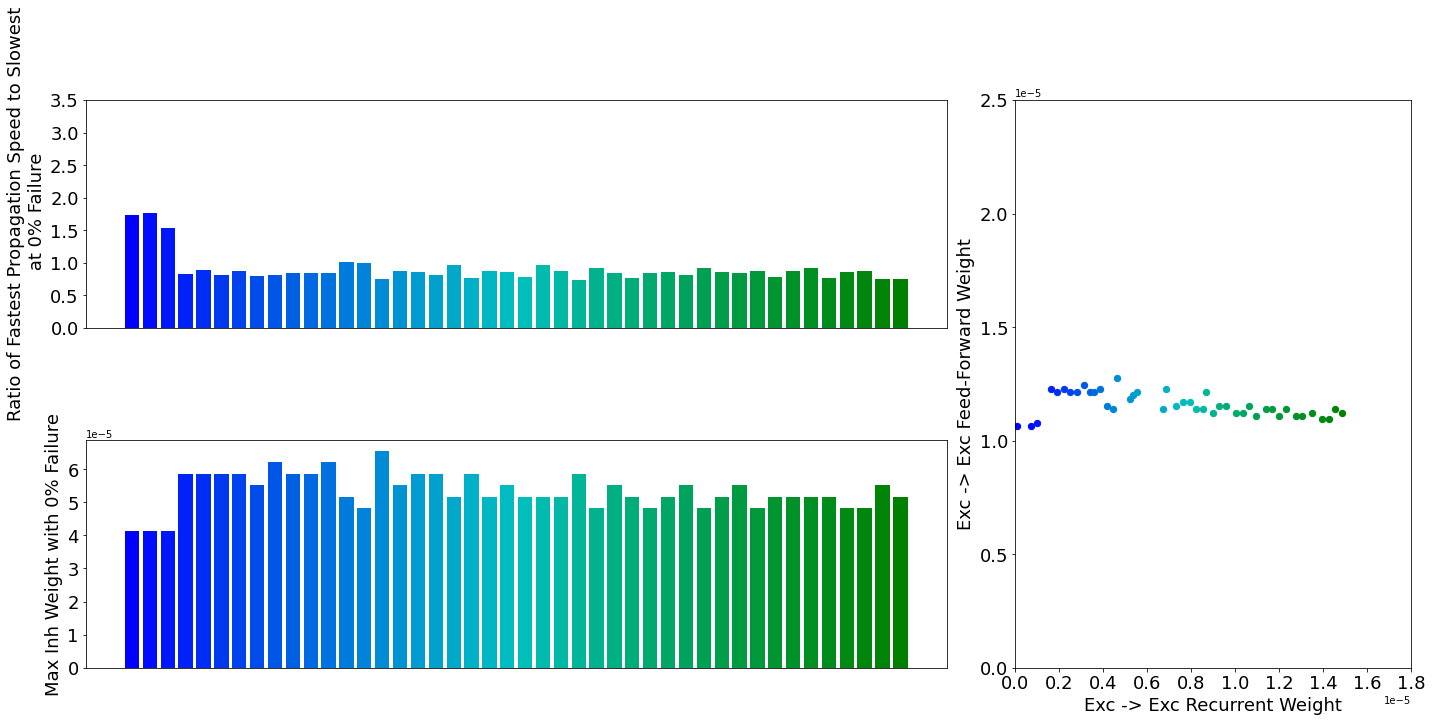

In [422]:
df_for_params = pickle.load(open('./data/exp_2020-07-01--13:42/stable_weights_per_08.p', 'rb'))
params_for_per_08 = [df_for_params.iloc(0)[idx] for idx in range(0, len(df_for_params), 2)]
graph_reliability_curve(params_for_per_08, res2)

### Results for 34% intralink connectivity (no adaptation)

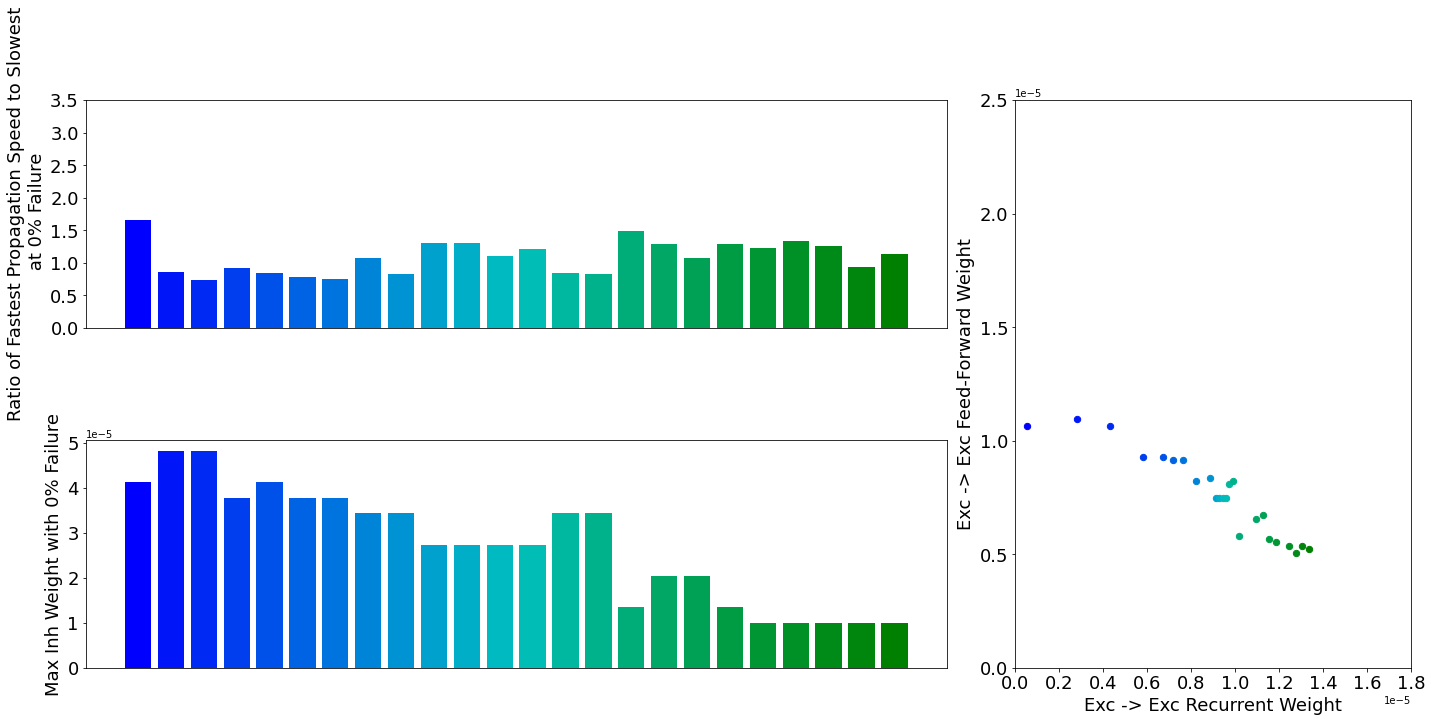

In [423]:
df_for_params = pickle.load(open('./data/exp_2020-07-01--13:42/stable_weights_per_34.p', 'rb'))
params_for_per_34 = [df_for_params.iloc(0)[idx] for idx in range(0, len(df_for_params), 2)]
graph_reliability_curve(params_for_per_34, res3)